In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

def prepare_price_data(file_name, year):
    df_prices = pd.read_csv(file_name, header=1, encoding='latin-1', sep=',')
    df_prices.columns = df_prices.columns.str.strip()
    year_str = str(year)
    if year_str not in df_prices.columns: return pd.DataFrame()
    df_year = df_prices[[year_str]].copy()
    df_year.rename(columns={year_str: 'Price (EUR/MWh)'}, inplace=True)
    df_year = df_year.dropna()
    num_hours = len(df_year)
    start_date = pd.to_datetime(f'{year}-01-01 00:00:00', utc=True)
    df_year.index = pd.date_range(start=start_date, periods=num_hours, freq='H', name='MTU')
    df_year['Year'] = year
    return df_year.reset_index()

Овде го земаме податочното множество и го припремаме за соодветна обработка. Иницијален мал проблем пред да почне да се тренира моделот е тоа што во податоците имаме мала неусогласеност, а тоа е што интервалот кој што ни кажува колку е струја произведено во даден интервал е на 15минути, а интервалот на цените ни е на 1 час. Проблемот го решаваме на начин што интервалите за производство ги собираме во групи по 4, ги сумираме и на нив и зимаме просек и со тоа можеме да добиеме интервали на производство за секој час. Со ова ги спремаме податоците за да можеме да го тренираме моделот со MLRRegressor.

In [31]:
def prepare_generation_data(file_name, year):
    df_gen = pd.read_csv(file_name, header=5, encoding='latin-1', sep=',')
    df_gen.columns = df_gen.columns.str.strip()
    df_gen.rename(columns={df_gen.columns[0]: 'MTU'}, inplace=True)
    cols_to_convert = [col for col in df_gen.columns if 'MW' in col]
    for col in cols_to_convert:
        df_gen[col] = df_gen[col].replace(['n/e', 'N/A', 'n/a', 'N/a', '-'], np.nan) 
        df_gen[col] = pd.to_numeric(df_gen[col], errors='coerce')
    df_gen['MTU'] = df_gen['MTU'].astype(str).str.split(' - ').str[0]
    df_gen['MTU'] = pd.to_datetime(df_gen['MTU'], format='%d/%m/%Y %H:%M:%S', utc=True)
    df_gen = df_gen.set_index('MTU')
    hourly_df = df_gen[cols_to_convert].resample('H').mean()
    hourly_df['Year'] = year
    if 'Solar (MW)' in hourly_df.columns:
        hourly_df.rename(columns={'Solar (MW)': 'Solar (MW) Mean'}, inplace=True)
    return hourly_df.reset_index()

Продолжуваме да ја дополнително средуваме податочното множество овде поконкретно ја средуваме датасето за тоа од какви извори се продавала струјата на берзата

In [32]:
def prepare_2025_price_data(file_name):
    df_prices = pd.read_csv(file_name, header=2, encoding='latin-1', sep=',')
    df_prices.columns = df_prices.columns.str.strip()
    df_prices.rename(columns={df_prices.columns[0]: 'MTU', df_prices.columns[1]: 'Price (EUR/MWh)'}, inplace=True)
    df_prices['MTU'] = df_prices['MTU'].astype(str).str.split(' - ').str[0]
    df_prices['MTU'] = pd.to_datetime(df_prices['MTU'], format='%d/%m/%Y %H:%M:%S', utc=True)
    df_prices = df_prices.set_index('MTU')
    df_prices['Price (EUR/MWh)'] = pd.to_numeric(df_prices['Price (EUR/MWh)'], errors='coerce')
    hourly_df = df_prices[['Price (EUR/MWh)']].resample('H').mean()
    hourly_df['Year'] = 2025
    return hourly_df.reset_index()

Овде се средуваат и ресамплираат податоците за цената за 2025 година

In [33]:
def add_time_features(df):
    if 'MTU' not in df.columns: return df
    df['Hour'] = df['MTU'].dt.hour
    df['DayOfWeek'] = df['MTU'].dt.dayofweek
    df['Month'] = df['MTU'].dt.month
    df['DayOfYear'] = df['MTU'].dt.dayofyear
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    days_in_year = df['MTU'].dt.is_leap_year.apply(lambda x: 366 if x else 365).iloc[0] if not df.empty else 365
    df['Day_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / days_in_year)
    df['Day_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / days_in_year)
    return df.drop(columns=['Hour', 'DayOfYear'])

Додаваме циклични временски карактеристики

In [34]:
def add_lag_features(df, lag_hours=[1, 2, 3, 24, 168]):
    if 'Price (EUR/MWh)' not in df.columns:
        # Лаг карактеристиките може да се пресметаат само ако цената е присутна
        print("Warning: Cannot add lag features, 'Price (EUR/MWh)' column is missing.")
        return df

    df = df.set_index('MTU')
    
    for lag in lag_hours:
        df[f'Price_Lag_{lag}h'] = df['Price (EUR/MWh)'].shift(lag)
        
    df = df.reset_index()
    return df

In [35]:
price_file_train = r"D:\FINKI\Pametni Gradovi\Prices 2011-2024 (HUPX).csv"
gen_file_2018 = r"D:\FINKI\Pametni Gradovi\2018 HU generation.csv"
gen_file_2024 = r"D:\FINKI\Pametni Gradovi\2024 HU generation.csv"
gen_file_2025 = r"D:\FINKI\Pametni Gradovi\2025 HU generation.csv"
price_file_2025 = r"D:\FINKI\Pametni Gradovi\2025 HU Generation (15minutes) - prices.csv"

print("--- Вчитување и претпроцесирање на податоци за тренирање (2018 & 2024) ---")
df_prices_2018 = prepare_price_data(price_file_train, 2018)
df_prices_2024 = prepare_price_data(price_file_train, 2024)

df_gen_2018 = prepare_generation_data(gen_file_2018, 2018)
df_gen_2024 = prepare_generation_data(gen_file_2024, 2024)

df_2018 = pd.merge(df_prices_2018, df_gen_2018, on=['MTU', 'Year'], how='inner')
df_2024 = pd.merge(df_prices_2024, df_gen_2024, on=['MTU', 'Year'], how='inner')
df_train = pd.concat([df_2018, df_2024], ignore_index=True)

--- Вчитување и претпроцесирање на податоци за тренирање (2018 & 2024) ---


C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\267513669.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_year.index = pd.date_range(start=start_date, periods=num_hours, freq='H', name='MTU')
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\267513669.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_year.index = pd.date_range(start=start_date, periods=num_hours, freq='H', name='MTU')
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\3297728821.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gen[col] = df_gen[col].replace(['n/e', 'N/A', 'n/a', 'N/a', '-'], np.nan)
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\3297728821.py:12

Податоците што ќе ни бидат потребни за тренирање од 2018 и 2024 година ги спојуваме во една табела за да полесно управуваме со нив. Заедно ги спојуваме и цените и изворите на ел. енергија.

In [36]:
df_train = add_time_features(df_train)
df_train = add_lag_features(df_train, lag_hours=[1, 24, 168]) # Додадено: Лагови од 1 час, 1 ден, 1 недела

In [37]:
df_gen_2025 = prepare_generation_data(gen_file_2025, 2025)
df_prices_2025 = prepare_2025_price_data(price_file_2025)

df_predict_full = pd.merge(df_prices_2025, df_gen_2025, on=['MTU', 'Year'], how='inner')
df_predict_full = add_time_features(df_predict_full)
df_predict_full = add_lag_features(df_predict_full, lag_hours=[1, 24, 168]) # Додадено: Лагови

# Сепарација на цената за 2025 за евалуација
df_2025_actual = df_predict_full[['MTU', 'Price (EUR/MWh)']].copy() 
df_2025_actual.rename(columns={'Price (EUR/MWh)': 'Actual Price (EUR/MWh)'}, inplace=True)
df_predict = df_predict_full.drop(columns=['Price (EUR/MWh)']).copy()

C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\3297728821.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gen[col] = df_gen[col].replace(['n/e', 'N/A', 'n/a', 'N/a', '-'], np.nan)
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\3297728821.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_gen[cols_to_convert].resample('H').mean()
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\1347153292.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_prices[['Price (EUR/MWh)']].resample('H').mean()


Како и за податоците за тренирање истото со табелите го правиме и за податоците за предвидување

In [ ]:
df_train.dropna(subset=['Price_Lag_168h'], inplace=True)

generation_cols = [col for col in df_train.columns if 'MW' in col]
lag_cols = [col for col in df_train.columns if 'Price_Lag_' in col]
all_features_cols = generation_cols + lag_cols

# ИМПУТАЦИЈА ЗА df_train
print("\nИмпутација на NaN вредности во df_train...")
cols_to_impute_train = all_features_cols + ['Price (EUR/MWh)']
for col in cols_to_impute_train:
    df_train[col].fillna(df_train.groupby('Month')[col].transform('mean'), inplace=True)

# ИМПУТАЦИЈА ЗА df_predict
# df_predict ќе има NaN во првите 168 часа за лаг карактеристиките.
print("Импутација на NaN вредности во df_predict...")
for col in all_features_cols:
    if col in df_predict.columns:
        df_predict[col].fillna(df_predict.groupby('Month')[col].transform('mean'), inplace=True)
    
df_train.fillna(df_train.mean(numeric_only=True), inplace=True)
df_predict.fillna(df_predict.mean(numeric_only=True), inplace=True)


Импутација на NaN вредности во df_train...
Импутација на NaN вредности во df_predict...


C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\1107547704.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(df_train.groupby('Month')[col].transform('mean'), inplace=True)
C:\Users\Stole\AppData\Local\Temp\ipykernel_26548\1107547704.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

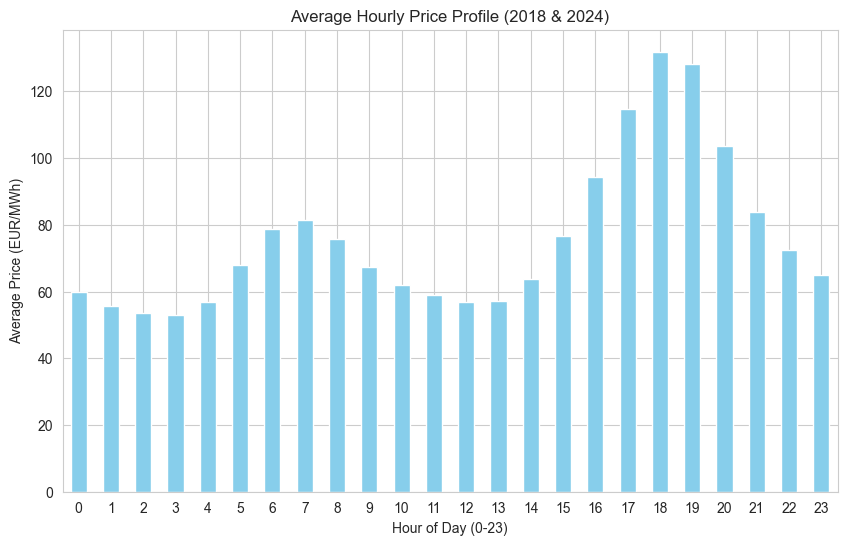

In [16]:

plt.figure(figsize=(10, 6))
hourly_price = df_train.groupby(df_train['MTU'].dt.hour)['Price (EUR/MWh)'].mean()
hourly_price.plot(kind='bar', color='skyblue')
plt.title('Average Hourly Price Profile (2018 & 2024)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(rotation=0)
plt.savefig('viz_1_average_hourly_price.png')
plt.show()

Споредба на просечна неделна цена (Day-Ahead Price vs. Hour)

Овде се зема просекот од цените за секој час во 2018 и 2024 година кои што ќе бидат користени за тренирачко множество

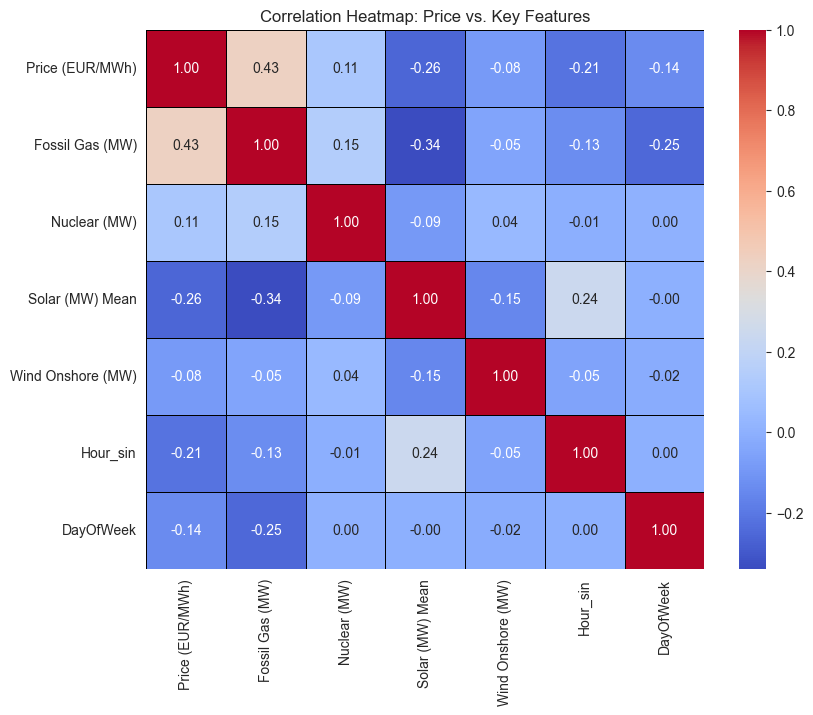

In [17]:
# 3.2. Корелациска Топлинска Мапа (Heatmap)
corr_cols = ['Price (EUR/MWh)', 'Fossil Gas (MW)', 'Nuclear (MW)', 'Solar (MW) Mean', 'Wind Onshore (MW)', 'Hour_sin', 'DayOfWeek']
plt.figure(figsize=(9, 7))
sns.heatmap(df_train[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('Correlation Heatmap: Price vs. Key Features')
plt.savefig('viz_2_correlation_heatmap.png')
plt.show()

Матрица на корелација која што сепак не ни открива некои значајни корелираности помеѓу атрибутите што и реалистично може да се каже затоа што не може поголем дел од овие да влијаат едни на други. 

Сепак благите зависности кои што можат да се видат помеѓу природен гас и соларната енергија ни алудираат дека нивната негативна корелација ни означува кога ја зголемуваме количината на ел. енергија добиена од сонце ни се намалува количината на ел. енергија добиена од горење на природен гас. 

Ова ние всушност и сакаме да се случува затоа што ова е и суштината на т.н. зелена транзиција и особено паметните енергетски системи како теми на овој предмет.

Втората најголема зависност од -0.26 (не е голема, ама сепак втора) помеѓу струјата добиена од фотоволтаици и цената на ел. енергија ни укажува на тоа дека доколку го зголемуваме количеството на добиена струја од ваков извор може на долг рок да имаме и потенцијално намалува на цената на ел. енергија за сите нас затоа што соларните панели се помала инвестиција него константното купување на фосилни горива од држави богати со ваков ресурс се со цел да ја задоволиме нашата потреба за струја што ја патем и правеше струјата поскапа и производството надвор од наша тотална контрола.

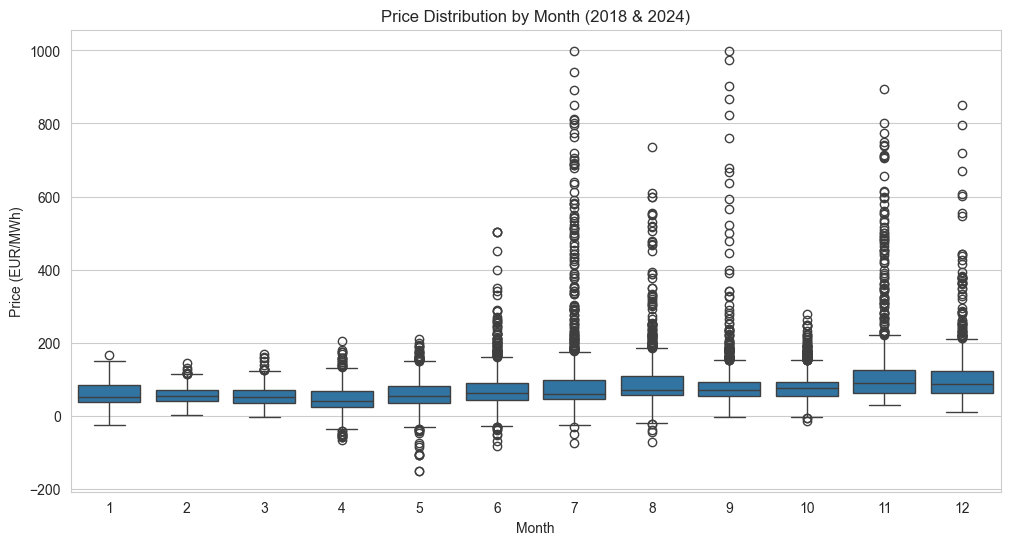

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Price (EUR/MWh)', data=df_train)
plt.title('Price Distribution by Month (2018 & 2024)')
plt.xlabel('Month')
plt.ylabel('Price (EUR/MWh)')
plt.savefig('viz_3_monthly_price_distribution.png')
plt.show()

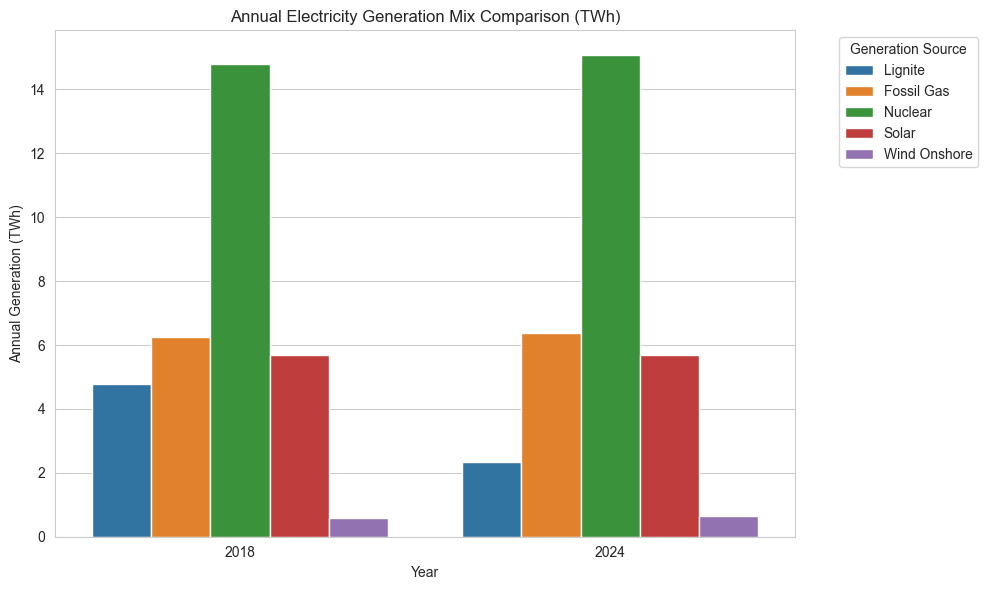

In [23]:
df_annual_gen = df_train.groupby('Year')[generation_cols].sum() / 1000000 # TWh
df_annual_gen_melted = df_annual_gen.melt(ignore_index=False, var_name='Source', value_name='Generation (TWh)').reset_index()

main_sources_map = {
    'Fossil Gas (MW)': 'Fossil Gas',
    'Nuclear (MW)': 'Nuclear',
    'Fossil Brown coal/Lignite (MW)': 'Lignite',
    'Solar (MW) Mean': 'Solar',
    'Wind Onshore (MW)': 'Wind Onshore'
}
df_main_mix = df_annual_gen_melted[df_annual_gen_melted['Source'].isin(main_sources_map.keys())].copy()
df_main_mix['Source'] = df_main_mix['Source'].map(main_sources_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_main_mix, x='Year', y='Generation (TWh)', hue='Source')
plt.title('Annual Electricity Generation Mix Comparison (TWh)')
plt.xlabel('Year')
plt.ylabel('Annual Generation (TWh)')
plt.legend(title='Generation Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('viz_4_annual_generation_mix_comparison.png')
plt.show()

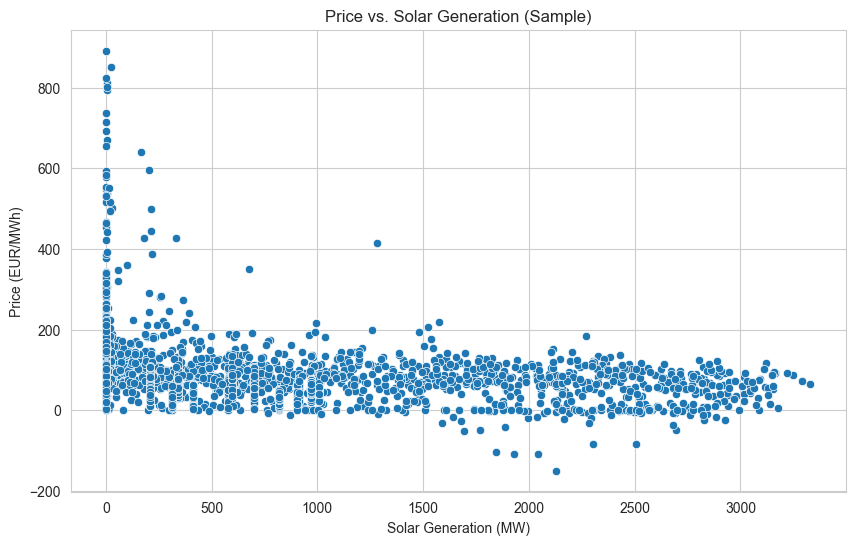

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Solar (MW) Mean', y='Price (EUR/MWh)', data=df_train.sample(n=5000))
plt.title('Price vs. Solar Generation (Sample)')
plt.xlabel('Solar Generation (MW)')
plt.ylabel('Price (EUR/MWh)')
plt.savefig('viz_5_solar_vs_price_scatter.png')
plt.show()

И овде може да се потврди една од претходните тези дека поголемо производство на струја од фотоволтаици може да придонесе до пониски цени на берзите.

In [39]:
print("\n--- 4. Тренирање на MLPRegressor Модел (Со Лаг Карактеристики) ---")

# 4.1. Избор на карактеристики и скалирање
features = [col for col in df_train.columns if col not in ['MTU', 'Price (EUR/MWh)', 'Year']]
target = 'Price (EUR/MWh)'

X = df_train[features].values
y = df_train[target].values

# Резервна опција за чистење на NaN (за робустност)
X[np.isnan(X)] = np.nanmean(X)
y[np.isnan(y)] = np.nanmean(y)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Поделба на податоци
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# 4.3. Дефинирање и тренирање на моделот (MLP Tuning)
# Зголемување на бројот на итерации и невроните за да се искористат новите лаг карактеристики
mlp_model = MLPRegressor(
    hidden_layer_sizes=(150, 100, 50), # Поголема мрежа
    activation='relu',
    solver='adam',
    max_iter=1000,                     # Повеќе итерации
    random_state=42,
    verbose=False,
    early_stopping=True,
    n_iter_no_change=30                # Подолга толеранција за подобро тренирање
)


print("Тренирање на MLP модел...")
mlp_model.fit(X_train, y_train.ravel())
print("MLP моделот е трениран.")


# 4.4. Евалуација на моделот
y_pred_scaled = mlp_model.predict(X_test)

# Враќање на предвидувањата во оригинална скала
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test)

# Евалуациски метрики
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("\n--- 5. Евалуација на Подобрениот Модел (MLP со Лаг) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} EUR/MWh")
print(f"Mean Absolute Error (MAE): {mae:.2f} EUR/MWh")
print(f"R-squared (R2): {r2:.4f}")


--- 4. Тренирање на MLPRegressor Модел (Со Лаг Карактеристики) ---
Тренирање на MLP модел...
MLP моделот е трениран.

--- 5. Евалуација на Подобрениот Модел (MLP со Лаг) ---
Root Mean Squared Error (RMSE): 47.11 EUR/MWh
Mean Absolute Error (MAE): 26.18 EUR/MWh
R-squared (R2): 0.7603



--- 6. Предвидување на цените за 2025 година ---
Пронајдени 55769 NaN вредности во X_2025. Замена со средна вредност.
Број на предвидени часа за 2025: 7967 (почнувајќи од час 0)
Први 5 предвидени цени за 2025: [104.96714259 105.14004055 100.62357122  75.52947533  72.70431951]

Евалуација на предвидувањата за 2025 (за достапните актуелни цени):
   RMSE: 29.92 EUR/MWh
   MAE: 20.30 EUR/MWh
   R2: 0.7603


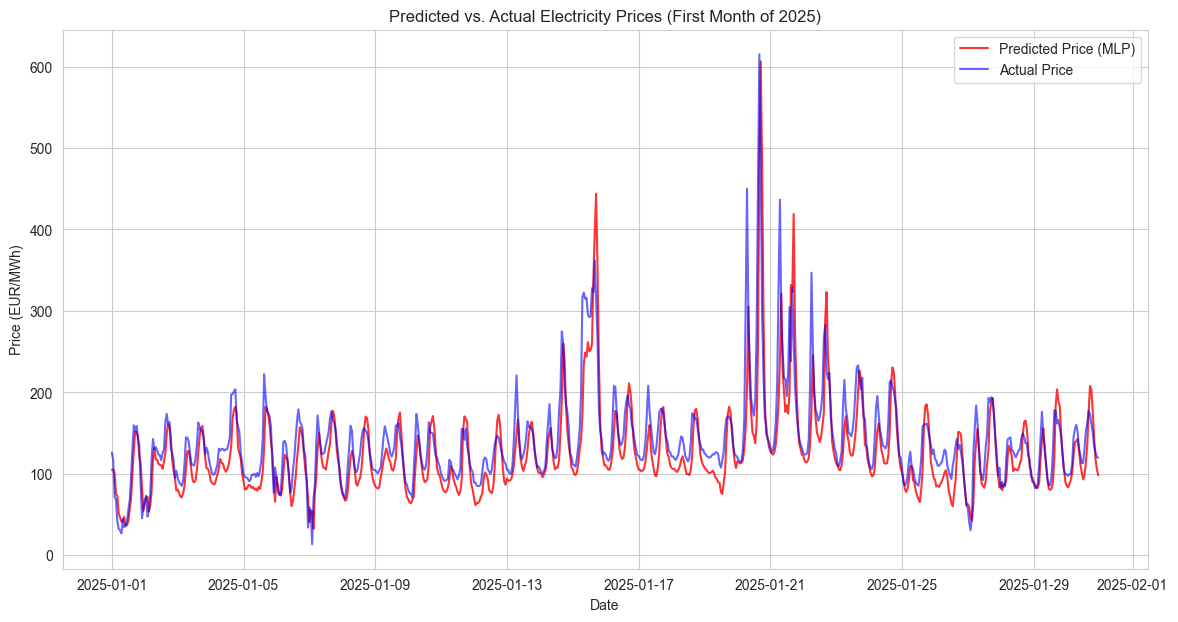

In [ ]:
print("\n--- 6. Предвидување на цените за 2025 година ---")

lag_to_check = 'Price_Lag_170h' if 'Price_Lag_170h' in df_predict.columns else 'Price_Lag_168h'

df_predict_cleaned = df_predict.dropna(subset=[lag_to_check]).copy()

df_predict_cleaned.fillna(df_predict_cleaned.mean(numeric_only=True), inplace=True)

X_2025 = df_predict_cleaned[features].values

if np.isnan(X_2025).any():
    print(f"Пронајдени {np.isnan(X_2025).sum()} NaN вредности во X_2025. Замена со средна вредност.")
    X_2025[np.isnan(X_2025)] = np.nanmean(X_2025)

X_2025_scaled = scaler_X.transform(X_2025)

y_2025_pred_scaled = mlp_model.predict(X_2025_scaled)
y_2025_pred = scaler_y.inverse_transform(y_2025_pred_scaled.reshape(-1, 1)).flatten()

df_forecast = df_predict_cleaned.copy()
df_forecast['Predicted Price (EUR/MWh)'] = y_2025_pred
df_forecast = pd.merge(df_forecast, df_2025_actual, on='MTU', how='left') 

df_forecast_valid = df_forecast.dropna(subset=['Actual Price (EUR/MWh)'])
rmse_2025 = np.sqrt(mean_squared_error(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)']))
mae_2025 = mean_absolute_error(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)'])
r2_2025 = r2_score(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)'])

print(f"Број на предвидени часа за 2025: {len(df_forecast)} (почнувајќи од час {df_forecast.index[0]})")
print(f"Први 5 предвидени цени за 2025: {y_2025_pred[:5]}")
print(f"\nЕвалуација на предвидувањата за 2025 (за достапните актуелни цени):")
print(f"   RMSE: {rmse_2025:.2f} EUR/MWh")
print(f"   MAE: {mae_2025:.2f} EUR/MWh")
print(f"   R2: {r2_2025:.4f}")

plt.figure(figsize=(14, 7))

N = 30 * 24 # Приближно првиот месец
plt.plot(df_forecast['MTU'].iloc[:N], df_forecast['Predicted Price (EUR/MWh)'].iloc[:N], label='Predicted Price (MLP)', color='red', alpha=0.8)
if 'Actual Price (EUR/MWh)' in df_forecast_valid.columns and df_forecast_valid['Actual Price (EUR/MWh)'].notna().any():
    plt.plot(df_forecast_valid['MTU'].iloc[:N], df_forecast_valid['Actual Price (EUR/MWh)'].iloc[:N], label='Actual Price', color='blue', alpha=0.6)

plt.title('Predicted vs. Actual Electricity Prices (First Month of 2025)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.legend()
plt.grid(True)
plt.show()

Евалуација на предвидувањата за 2025 (за достапните актуелни цени):
   RMSE: 29.92 EUR/MWh
   MAE: 20.30 EUR/MWh
   R2: 0.7603
Предвидувањето започнува од: 2025-01-01 00:00:00+00:00


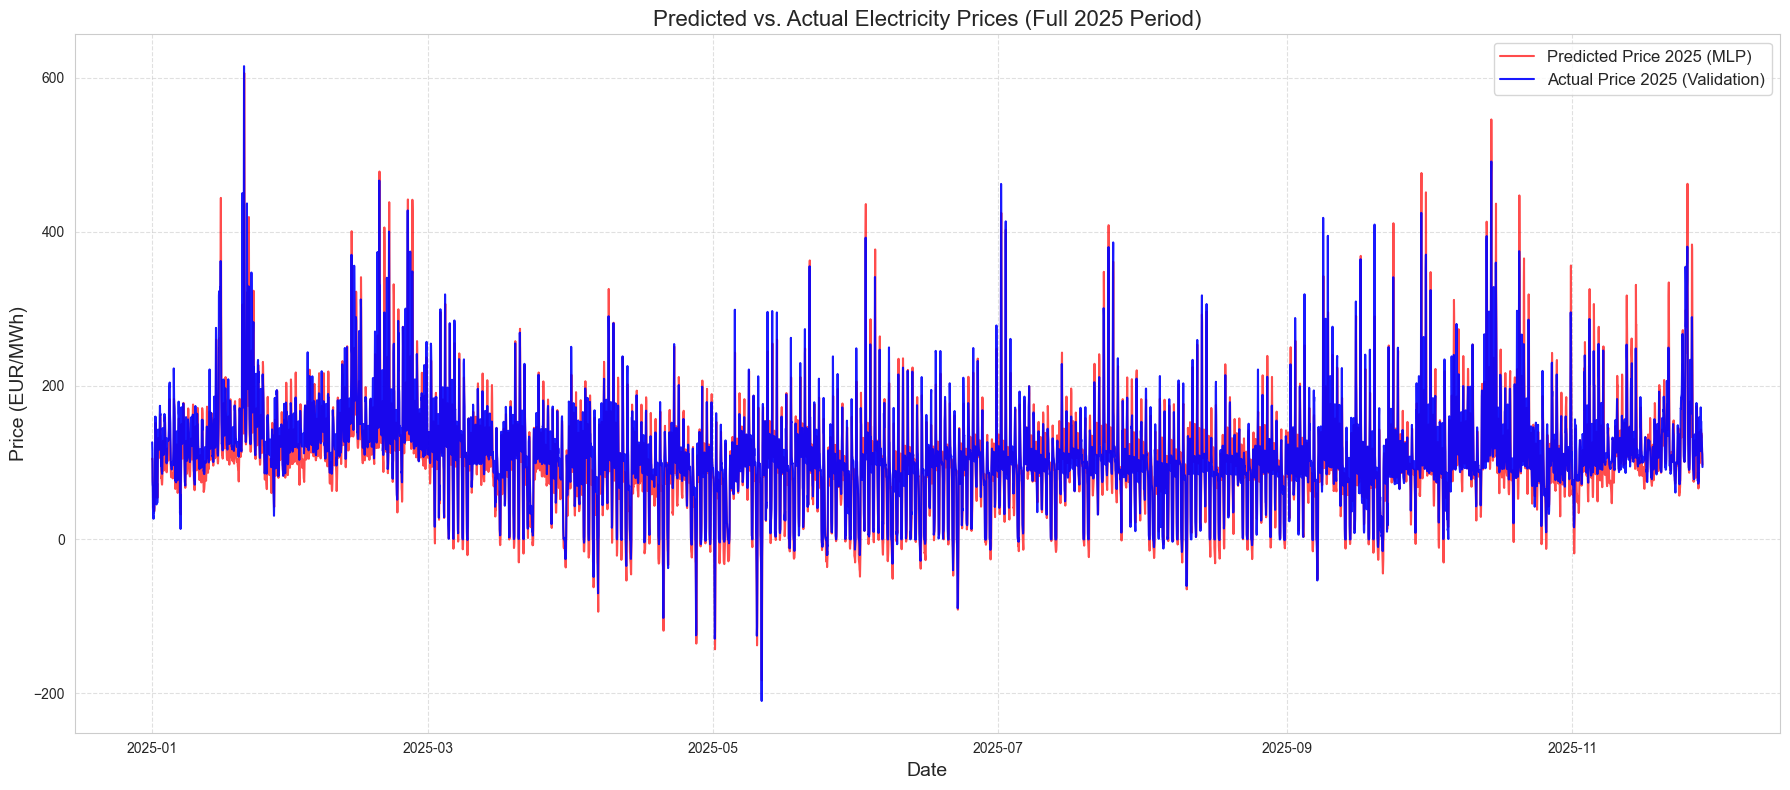

In [ ]:
df_forecast_valid = df_forecast.dropna(subset=['Actual Price (EUR/MWh)']).copy()
rmse_2025 = np.sqrt(mean_squared_error(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)']))
mae_2025 = mean_absolute_error(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)'])
r2_2025 = r2_score(df_forecast_valid['Actual Price (EUR/MWh)'], df_forecast_valid['Predicted Price (EUR/MWh)'])

# --- Генерирање на графиконот за цела година ---
plt.figure(figsize=(18, 8))

# Предвидени цени за целата година (или до каде што оди df_forecast)
plt.plot(df_forecast['MTU'], df_forecast['Predicted Price (EUR/MWh)'], 
         label='Predicted Price 2025 (MLP)', color='red', alpha=0.7)

# Реални цени (достапни само до крајот на Ноември 2025)
# Ги користиме само валидните податоци (каде што Actual Price не е NaN)
if 'Actual Price (EUR/MWh)' in df_forecast_valid.columns and df_forecast_valid['Actual Price (EUR/MWh)'].notna().any():
    plt.plot(df_forecast_valid['MTU'], df_forecast_valid['Actual Price (EUR/MWh)'], 
             label='Actual Price 2025 (Validation)', color='blue', alpha=0.9, linewidth=1.5)

plt.title('Predicted vs. Actual Electricity Prices (Full 2025 Period)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (EUR/MWh)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('viz_8_2025_price_prediction_full_year_comparison.png')
plt.show()


--- 7. Економска Анализа: Општинска Паметна Батерија ---

Параметри на батеријата: 2 MWh / 1 MW
Вкупен приход од трговија (за симулирани 1500 часа): 10,397.74 EUR
Проекција на годишен приход: 60,722.77 EUR


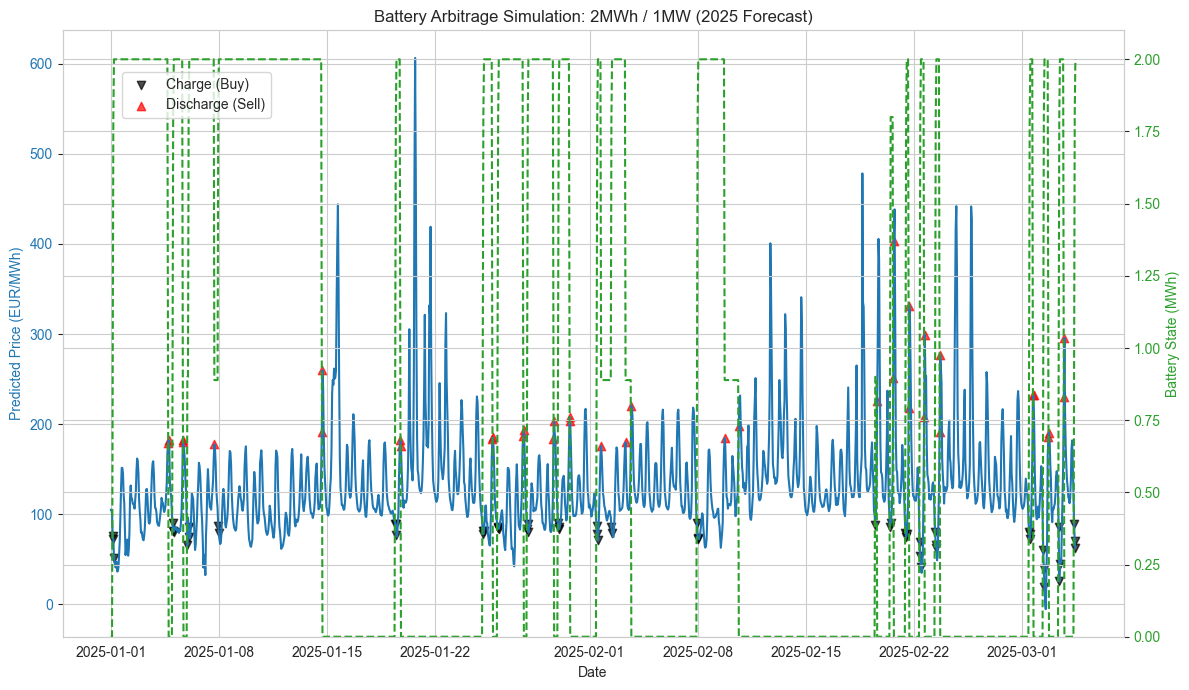

Generated viz_8_battery_arbitrage_simulation.png


In [45]:
print("\n--- 7. Економска Анализа: Општинска Паметна Батерија ---")

BATTERY_CAPACITY_MWh = 2 
CHARGE_EFFICIENCY = 0.9 
DISCHARGE_EFFICIENCY = 0.9 
BATTERY_POWER_MW = 1

df_sim = df_forecast.head(1500).copy() 

price_low = df_sim['Predicted Price (EUR/MWh)'].quantile(0.15)
price_high = df_sim['Predicted Price (EUR/MWh)'].quantile(0.85)

df_sim['Battery State (MWh)'] = 0.0
df_sim['Action (MW)'] = 0.0 
df_sim['Revenue (EUR)'] = 0.0

battery_state = 0.0
total_revenue = 0.0

for index, row in df_sim.iterrows():
    current_price = row['Predicted Price (EUR/MWh)']
    action = 0 

    # Обид за полнење (Купување)
    if current_price < price_low and battery_state < BATTERY_CAPACITY_MWh:
        charge_needed = BATTERY_CAPACITY_MWh - battery_state
        charge_amount = min(BATTERY_POWER_MW, charge_needed / CHARGE_EFFICIENCY) 
        
        action = -charge_amount
        battery_state += charge_amount * CHARGE_EFFICIENCY
        revenue_change = action * current_price * -1

    # Обид за празнење (Продажба)
    elif current_price > price_high and battery_state > 0:
        discharge_available = battery_state * DISCHARGE_EFFICIENCY
        discharge_amount = min(BATTERY_POWER_MW, discharge_available)
        
        action = discharge_amount
        battery_state -= discharge_amount / DISCHARGE_EFFICIENCY
        revenue_change = action * current_price
        
    else:
        revenue_change = 0
        
    df_sim.loc[index, 'Action (MW)'] = action
    df_sim.loc[index, 'Battery State (MWh)'] = battery_state
    df_sim.loc[index, 'Revenue (EUR)'] = revenue_change
    total_revenue += revenue_change

average_hourly_revenue = total_revenue / len(df_sim)
annual_revenue_projection = average_hourly_revenue * 8760 

print(f"\nПараметри на батеријата: {BATTERY_CAPACITY_MWh} MWh / {BATTERY_POWER_MW} MW")
print(f"Вкупен приход од трговија (за симулирани {len(df_sim)} часа): {total_revenue:,.2f} EUR")
print(f"Проекција на годишен приход: {annual_revenue_projection:,.2f} EUR")

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Price (EUR/MWh)', color=color)
ax1.plot(df_sim['MTU'], df_sim['Predicted Price (EUR/MWh)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Battery State (MWh)', color=color)
ax2.plot(df_sim['MTU'], df_sim['Battery State (MWh)'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, BATTERY_CAPACITY_MWh + 0.1)

ax1.scatter(df_sim[df_sim['Action (MW)'] < 0]['MTU'], 
            df_sim[df_sim['Action (MW)'] < 0]['Predicted Price (EUR/MWh)'], 
            marker='v', color='black', label='Charge (Buy)', alpha=0.7)
ax1.scatter(df_sim[df_sim['Action (MW)'] > 0]['MTU'], 
            df_sim[df_sim['Action (MW)'] > 0]['Predicted Price (EUR/MWh)'], 
            marker='^', color='red', label='Discharge (Sell)', alpha=0.7)

fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.title(f'Battery Arbitrage Simulation: {BATTERY_CAPACITY_MWh}MWh / {BATTERY_POWER_MW}MW (2025 Forecast)')
plt.tight_layout()
plt.savefig('viz_8_battery_arbitrage_simulation.png')
plt.show()
print("Generated viz_8_battery_arbitrage_simulation.png")